In [1]:
# Import general packages
import sys
import os
import re
import glob
import json
import gzip
import itertools
from tqdm.auto import tqdm
import copy
from pathlib import PurePath

# Parallel processing
from joblib import Parallel, delayed

# import data and math packages
import numpy as np
import pandas as pd
from pandarallel import pandarallel
 
import networkx as nx
import matplotlib.pyplot as plt

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

from abnumber import Chain
from abnumber.exceptions import ChainParseError, MultipleDomainsChainParseError

# working with structures
import prody as pr
import pymol as pml

import requests
# Working with sequences
import pyfastx
import swalign
# choose your own values here… 2 and -1 are common.
match = 2#
mismatch = -1
scoring = swalign.NucleotideScoringMatrix(match, mismatch)
sw = swalign.LocalAlignment(scoring)  # you can also choose gap penalties, etc...

import torch
from allennlp.commands.elmo import ElmoEmbedder
from pathlib import Path

model_dir = Path('/nfs/baron1/nolde/zhalevsky/uniref50_v2/')  # Seqvec data
weights = model_dir / 'weights.hdf5'
options = model_dir / 'options.json'
seqvec  = ElmoEmbedder(options,weights,cuda_device=0) # cuda_device=-1 for CPU

import Bio.PDB 
import Bio.PDB.ccealign
from Bio.PDB.ccealign import run_cealign

# Part 2

In [2]:
# Read covadab with CDRs
# Select only human Abs
# Extract pdbids
# Add pdbids from rcsb search:
#      (Scientific Name of the Source Organism is Severe acute respiratory syndrome coronavirus 2 OR
#       Scientific Name of the Source Organism is Severe acute respiratory syndrome coronavirus) AND
#      Scientific Name of the Source Organism is Homo Sapiens AND
#      Structure Title has any of words (antibody, antibodies, Fab, Fabs)
# Download pdb structures from the rcsb sever
# For structures of human antibodies in the covadab database process structure file to 
# find Abs H and L chain and RBD chain
# split pdb file to H+L+RBD chains and H+L chains only fitted to reference RBD structure
# Process pdb files which are not in the covadb database
# Fit Ab-RBD to ref complex and calculates decart coordinates of 3 points for Ab
#          1. center of mass of RBD heavy atoms interacting with Ab
#          2. center of mass of Ab heavy atoms interacting with RBD
#          3. center of CA atoms of Av variable domain
# Write unfiltered database
# Drop Ab not interacting with RBD (residue 333-527) and write next database version
# Calculate Seqvec embedded vectors for CDR[HL][1-3] and plot distance 
# between embedded vectors vs distance between epitopes map
# Delete outliers based on plotted map and save the database
# Drop duplicates on set of 6 RBD sequences (keep only last entry)
# 

In [3]:
# I/O files locataion
datadir = '/kate1/nolde/Ncom_2025' # path to I/O directory
dbfname = 'covadab_allcdr.json'                     # input file (output of part 1)
newpdblist = 'list2.txt'                            # file with additional pdbids (see cell above)
ref_rbd = 'ref.pdb'                                  # reference RBD structure from pdb 7LOP
ref_fn = str(PurePath(datadir, ref_rbd))
ref_ace = 'ace2.pdb'                                 # Ace2 structure of Ace2-RBD complex (6m0j) fitted to refrbd
ace2_fn = str(PurePath(datadir, ref_ace))
pdbrawdir = str(PurePath(datadir, 'pdb_raw'))         # Directory to download pdb files
pdbcleandir = str(PurePath(datadir, 'pdb_clean'))     # Store only RBD and 2 Ab chains
pdbabdir = str(PurePath(datadir, 'pdb_clean_ab_only')) #  Store only Abs chains
rbdseqs = 'rbd_seqs.fasta'                            # Output all RBD sequences
outfile1 = 'covidab_pdb_rbd_p1_1.json'                  # Output nonfiltered database with duplicates, non-rbd bindings etc
outfile2 = 'covidab_pdb_rbd_p2_1.json'                  # Output filtered for complexes binds with RBD
outfile3 = 'covidab_pdb_rbd_p3_1.json'                  # Output filtered for outliers based on Seqvec-Epitope distances map
outfile4 = 'covidab_pdb_rbd_p4_1.json'                  # Output filtered for Ab with unique CDRHL[1-3] sequences
outfile5 = 'covidab_pdb_rbd_p5_1.json'                  # Output filtered for Ab with unique CDRHL[1-3] sequences and correct Ab's name

In [4]:
covadab = pd.read_json(PurePath(datadir, dbfname))

In [5]:
# filter entries containing pdb structure
covadab['Structures'] = covadab['Structures'].str.upper()
covadab_pdb = covadab[covadab['Structures'].str.contains('WWW') == True].copy()
print(len(covadab_pdb))

516


In [6]:
### IMPORTANT PART ###
# SELECT ONLY HUMAN ABs vs RBD
hrbds = covadab_pdb[
    (covadab_pdb['Binds to'].str.contains('SARS-CoV2')) & 
    (covadab_pdb['Protein + Epitope'] == 'S; RBD') &
    (covadab_pdb['Heavy V Gene'].str.contains('Human')) &
    (covadab_pdb['Light V Gene'].str.contains('Human'))]

In [7]:
qid = re.compile('[1-9][0-9A-Za-z]{3}')
pdbids = list()
for index, row in hrbds.iterrows():
    pdbs = row['Structures']
    q = qid.findall(pdbs)
    if q is None:
        print(row)
    else:
        pdbids.extend(q)
        
pdbids = set(pdbids)

In [8]:
print(len(pdbids))

584


In [9]:
# Additional pdbids
with open(PurePath(datadir, newpdblist), 'r') as f1:
    newids = set(f1.readline()[:-1].split(','))
#pdbids = list(set(pdbids+list1))
#print(len(pdbids))
pdbids = pdbids.union(newids)
print(len(pdbids))

903


In [10]:
print(covadab_pdb.keys())

Index(['Name', 'Ab or Nb', 'Binds to', 'Doesn't Bind to', 'Neutralising Vs',
       'Not Neutralising Vs', 'Protein + Epitope', 'Origin', 'VHorVHH', 'VL',
       'Heavy V Gene', 'Heavy J Gene', 'Light V Gene', 'Light J Gene', 'CDRH3',
       'CDRL3', 'Structures', 'ABB Homology Model (if no structure)',
       'Sources', 'Date Added', 'Last Updated', 'Update Description',
       'Notes/Following Up?', 'Unnamed: 23', 'Unnamed: 24', 'CDRH1', 'CDRH2',
       'CDRL1', 'CDRL2'],
      dtype='object')


In [11]:
# download pdb file if present otherwise mmcif 
def pdb_mmcif_download(pdbid, datadir):
    # Create a session
    session = requests.Session()

# Define a retry strategy
    retry_strategy = Retry(
    total=5,  # Total number of retries
    backoff_factor=1,  # Waits 1 second between retries, then 2s, 4s, 8s...
    status_forcelist=[429, 500, 502, 503, 504],  # Status codes to retry on
    allowed_methods=["HEAD", "GET", "OPTIONS"]  # Methods to retry
    )

    # Mount the retry strategy to the session
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    urlpdb = f'https://files.rcsb.org/download/{pdbid}.pdb'
    pdb = f'{datadir}/{pdbid}.pdb'
    urlcif = f'https://files.rcsb.org/download/{pdbid}.cif'
    cif = f'{datadir}/{pdbid}.cif'
    
    if session.get(urlpdb, stream=True).status_code == 200:
        dsize = int(session.get(urlpdb, stream=True).headers['Content-length'])
        if os.path.exists(pdb) and os.path.getsize(pdb) >= dsize:
            return pdb # File already downloaded and has reliable size
        else:
            with open(pdb, 'wb') as file_handle:  # wb means Write Binary
                file_handle.write(session.get(urlpdb, stream=True).content)
            return pdb
    elif session.get(urlcif, stream=True).status_code == 200:
        dsize = int(session.get(urlcif, stream=True).headers['Content-length'])
        if os.path.exists(cif) and os.path.getsize(cif) >= dsize:
            return cif # File already downloaded and has reliable size
        else:
            with open(cif, 'wb') as file_handle:  # wb means Write Binary
                file_handle.write(session.get(urlcif, stream=True).content)
            return cif
    else:
        return None
        

In [12]:
if not os.path.exists(pdbrawdir):
    os.makedirs(pdbrawdir)
result = Parallel(n_jobs=8)(delayed(pdb_mmcif_download)(pdbid, pdbrawdir) for pdbid in tqdm(list(pdbids)))

  0%|          | 0/903 [00:00<?, ?it/s]

In [13]:
# download pdb_seqres.txt if not exist or small size
seq = PurePath(datadir, 'pdb_seqres.txt')
url = 'https://files.rcsb.org/pub/pdb/derived_data/pdb_seqres.txt'
if requests.get(url, stream=True).status_code == 200:
    dsize = 300000
    if os.path.exists(seq) and os.path.getsize(seq) >= dsize:
        pass
    else:
        with open(seq, 'wb') as file_handle:  # wb means Write Binary
            file_handle.write(requests.get(url, stream=True).content)
pdb_seqres = str(PurePath(datadir, 'pdb_seqres.txt'))

In [14]:
fnames = [x for x in result if x is not None]
print(len(fnames))

903


In [15]:
# filter pdb file by ORGANISM_TAXID record 
# only Homo sapiens or makaka + Severe acute respiratory syndrome coronavirus 2 are selected
def filter_sars_human(fname):
    fl1 = False
    fl2 = False
    with open(fname, 'r') as f:
        if fname.endswith('.pdb'):
            for line in f:
                if re.search('(?i)ORGANISM_TAXID:(\s+)9606', line):
                    fl1 = True
                elif re.search('(?i)ORGANISM_TAXID:(\s+)9544', line):
                    fl1 = True
                elif re.search('(?i)EXPRESSION_SYSTEM_TAXID:(\s+)9606', line):
                    fl1 = True
                elif re.search('(?i)ORGANISM_TAXID:(\s+)2697049', line):
                    fl2 = True
                elif re.search('(?i)ORGANISM_TAXID:(\s+)2901879', line): # SARS-COV-1 but errors occur
                    fl2 = True
                elif re.search('(?i)SARS-COV.*2', line):
                    fl2 = True
                elif re.search('(?i)SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS.2', line):
                    fl2 = True
                if fl1 and fl2:
                    return True
            return False   
        else:
            for line in f:
                if re.search('(?i)sample.* 9606 ', line):
                    fl1 = True
                elif re.search('(?i)sample.* 9544 ', line):
                    fl1 = True
                elif re.search('(?i)sample.* \'Homo sapiens\'', line):
                    fl1 = True
                elif re.search('(?i)sample.* \'Macaca Mulatta\'', line):
                    fl1 = True
                elif re.search('(?i)sample.* 2697049 ', line):
                    fl2 = True
                elif re.search('(?i)sample.* \'Severe acute respiratory syndrome coronavirus 2\'', line):
                    fl2 = True
                elif re.search('(?i)sample.* 2901879 ', line):
                    fl2 = True
                elif re.search('(?i)sample.* SARS-CoV-2', line):
                    fl2 =True
                elif re.search('(?i)sample.* 2019-nCoV', line):
                    fl2 = True
                elif re.search('(?i)SARS-COV.*2', line):
                    fl2 = True
                if fl1 and fl2:
                    return True
            return False

In [16]:
newfnames = [fname for fname in fnames if filter_sars_human(fname)]
nothuman = [fname for fname in fnames if not filter_sars_human(fname)]
print(len(newfnames), len(nothuman))
print(nothuman)
allfnames = fnames
fnames = newfnames

897 6
['/kate1/nolde/Ncom_2025/pdb_raw/8DT3.pdb', '/kate1/nolde/Ncom_2025/pdb_raw/7TTY.pdb', '/kate1/nolde/Ncom_2025/pdb_raw/8GJM.cif', '/kate1/nolde/Ncom_2025/pdb_raw/7TTX.pdb', '/kate1/nolde/Ncom_2025/pdb_raw/7U0L.cif', '/kate1/nolde/Ncom_2025/pdb_raw/7TTM.pdb']


In [17]:
# 7TTY non  SArs-Cov2
# 7U0L  non Ab non  SArs-Cov2; 
# 8GB5, 8GB6, 8GB7, 8GB8  makaka 
# 8GJM mouse
# 8DT3 mouse
# 7TTX, 7TTM Sarbecovirus

In [18]:
# Add makaka Ab because they were classified in https://doi.org/10.1038/s41586-022-04980-y
# fnames.extend([x for x in nothuman if '8GB' in x])

In [19]:
def molnames_from_pdbheader(fname):
    pnames = []
    try:
        cifflag = fname.endswith('.cif')
        if cifflag:
            header = pr.parseMMCIF(fname, model=0, header=True)
        else:
            header = pr.parsePDB(fname, model=0, header=True)
 
        for p in header['polymers']:
            pnames.append(p.name)
        return pnames
    
    except (ValueError, KeyError) as e:
        print(f'Bad file: {fname} {str(e)}')
        return None

In [20]:
pr.confProDy(verbosity='critical')
allpnames = Parallel(n_jobs=24)(delayed(molnames_from_pdbheader)(fname) for fname in tqdm(fnames))

  0%|          | 0/897 [00:00<?, ?it/s]

In [21]:
print(len([x for x in result if x[0]]))

903


In [22]:
# Chain classification based on chain description in the structure pdb file ()

pnames = set([x for xs in allpnames if xs is not None for x in xs])
pnamesd = {
    'RBD': [],
    'H': [],
    'L': [],
    'Nano': [],
    'Fusion': [],
    'Darpin': [],
    'SC': [],
    'HorL': [],
    'OTHER': []}

for _pname in pnames:
    pname = _pname.upper()
    if re.search('(SINGLE CHAIN)', pname):
        pnamesd['SC'].append(pname)
    elif re.search('(H.AVY|[Hh]eavy)', pname):
        pnamesd['H'].append(pname)
    elif re.search('(LIG[HN]T|[Ll]ig[hn]t)', pname):
        pnamesd['L'].append(pname)
    elif re.search('(NANOBODY|Nanobody|NAN|VHH)', pname):
        pnamesd['Nano'].append(pname)
    elif re.search('(FAB H|H CHAIN|CHAIN H|VH|H$|IGH@ PROTEIN|-HC)', pname):
        pnamesd['H'].append(pname)
    elif re.search('(FAB L|KAPPA|LAMBDA|L CHAIN|L CHIAN|CHAIN L|VL|L$|IGK@ PROTEIN|-LC)', pname):
        pnamesd['L'].append(pname)
    elif re.search('(RBD|RECEPTOR BINDING DOMAIN|S1|SPIKE|MERS S|S PROTEIN|SURFACE GLYCOPROTEIN|Spike glycoprotein)', pname):
        pnamesd['RBD'].append(pname)
    elif re.search('(FUSION)', pname):
        pnamesd['Fusion'].append(pname)
    elif re.search('(DARPIN|SR22)', pname):
        pnamesd['Darpin'].append(pname)
    elif re.search('(SCFV|GW01|16L9|AB08|ANTIBODY|BN03|N3113|NB70|N3130)', pname):
        pnamesd['SC'].append(pname)
    elif re.search('(F26G19|FAB)', pname):
        pnamesd['HorL'].append(pname)
    elif re.search('(Antibody Cr3022)', pname):
        pnamesd['H'].append(pname)
    else:
        pnamesd['OTHER'].append(pname)

In [23]:
print(pnamesd['OTHER'])

['3E8', '7F3 FV', 'S309-KC', 'PROCESSED ANGIOTENSIN-CONVERTING ENZYME 2', 'NBC1', 'SODIUM-DEPENDENT NEUTRAL AMINO ACID TRANSPORTER B(0)AT1', 'PRO-SER-LYS-ARG-SER-PHE-ILE-GLU-ASP-LEU-LEU-PHE-ASN', 'ANGIOTENSIN-CONVERTING ENZYME 2', 'SA55_KC', 'NUCLEOPROTEIN']


In [24]:
if not os.path.exists(pdbabdir):
    os.makedirs(pdbabdir)
if not os.path.exists(pdbcleandir):
    os.makedirs(pdbcleandir)

In [25]:
# CDRs from aminoacid sequence of chain
def extr_cdr_from_aaseq(seq):
    res = {}
    for chain in Chain.multiple_domains(seq, scheme='imgt', allowed_species='human', assign_germline=False):
    # chain = Chain(seq, scheme='imgt', allowed_species='human', assign_germline=False)
        if chain.is_heavy_chain():
            pref = 'CDRH'
        elif chain.is_light_chain():
            pref = 'CDRL'
        else:
            return None
            
        for num, cdr in enumerate([chain.cdr1_seq, chain.cdr2_seq, chain.cdr3_seq], start=1):
            res[f'{pref}{num}'] = cdr
    return res

def extr_cdr_from_twoseq(H, L):
    res1 = extr_cdr_from_aaseq(H)
    res2 = extr_cdr_from_aaseq(L)
    # print(res1, res2)
    res1.update(res2)
    return res1


In [26]:
# Process pdb structure file
# Make chain classification
# Finding triplets of RBD+H+L chains interacting with each other
# For each Ab selecting tiplet with maximimum number of contacts
# fit Ab+RBD to reference RBD structure and write pdb files with
# Ab+RBD and Ab only structure

def procpdbnew(fname, ref, pdb_seqres, debug=False):
    if debug:
        def dbgprint(*args):
            print(args)
    else:
        def dbgprint(*args):
            pass
    pdbseqs = pyfastx.Fasta(pdb_seqres, build_index=True)        
    gchids = {}
    regchids = {}
    dbgprint(fname)
    cifflag = fname.endswith('.cif')
    try:
        if cifflag:
            pdb_, cifheader = pr.parseMMCIF(fname, header=True)
            header = cifheader['polymers']
            pdbname = fname.split('/')[-1].replace('cif', 'pdb')
        else:
            pdb_, pdbheader = pr.parsePDB(fname, header=True)
            header = pdbheader['polymers']
            pdbname = fname.split('/')[-1].replace('cif', 'pdb')
        pdb = pdb_.select('protein')
        ca = pdb.select('calpha')
    except ValueError:
        return False, f'Bad file: {fname}'
    except KeyError:
        return False, f'Bad file: {fname}'
   #  print(fname, pdbheader)
    pdbid = pdb.getTitle()
    if len(header) == 0:
        return False, f'Bad pdb {pdbid} {fname}'
     
    chidsd = {
        'RBD': [],
        'L': [],
        'H': [],
        'SC': [],
        'HorL': []
    }
    for p in header:
        for k in chidsd.keys():
            if p.name in pnamesd[k]:
                chidsd[k].append(p.chid)
                gchids[(pdbid, p.chid)] = k
                break

    if (len(chidsd['RBD']) == 0) or \
        (len(chidsd['H']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
        (len(chidsd['L']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
        (len(chidsd['H']) + len(chidsd['L']) + len(chidsd['HorL']) + 2*len(chidsd['SC'])) < 2:
        return False, f'pdb {pdbid} does not contain RBD + H + L chains'

    for c in chidsd['HorL']:
        try:
            # print(f'pdb {pdbid} chain {c} H or L?')
            seq = str(pdbseqs[f'{pdbid.lower()}_{c}'])
           #  seq = ca.select(f'chid {c}').getSequence()
            cdr = extr_cdr_from_aaseq(seq)
            # print('HorL CDR', c, cdr)
            if "CDRL3" in cdr.keys():
                chidsd['L'].append(c)
                gchids[(pdbid, c)] = 'L'
                # print('Chain L')
            elif "CDRH3" in cdr.keys():
                chidsd['H'].append(c)
                gchids[(pdbid, c)] = 'H'
                # print('Chain H')
            else:
                print(f'Error pdb {pdbid} chain {c} neither H nor L!')
                continue
        except ChainParseError:
            continue
                
    for c in chidsd['SC']:
        try:
            # print(f'pdb {pdbid} chain {c} Single Chain')
            seq = str(pdbseqs[f'{pdbid.lower()}_{c}'])
            # seq = ca.select(f'chid {c}').getSequence()
            cdr = extr_cdr_from_aaseq(seq)
            if ("CDRL3" in cdr.keys()) and ("CDRH3" in cdr.keys()):
                chidsd['L'].append(c + '_L__')
                # print('Chain L')
                chidsd['H'].append(c + '_H__')
                # print('Chain H'f)
            else:
                dbgprint(f'Error pdb {pdbid} chain {c} CDRH3 or CDRL3 not found')
                continue
        except ChainParseError:
            continue

    dcut = 4.5
    dcutHL = 4.5
    G = nx.Graph()
    dbgprint('chidsd=', chidsd)
    for r in chidsd['RBD']:
        for c in chidsd['L']:
            try:
                c0 = c[:-4] if len(c)>4 else c
                seq = str(pdbseqs[f'{pdbid.lower()}_{c0}'])
                # seq = ca.select(f'chid {c0}').getSequence()
                cdr = extr_cdr_from_aaseq(seq)
                if "CDRL3" in cdr.keys():
                    cdr3 = pdb.select(f'chid {c0} and sequence {cdr["CDRL3"]}')
                    if cdr3:
                        last = cdr3.getResnums()[-1] + 12
                        first = max(1, cdr3.getResnums()[0] - 95)
                        regchids[c] = (first, last)
                        s = pdb.select(f'exwithin {dcut} of chid {r} and chid {c0}' + 
                                       f' and resnum {first} to {last}')
                        weight = 0 if s is None else len(s)
                        dbgprint(f'RBD-L {r}-{c} {weight}')
                        G.add_edge(r, c, weight=weight, ind=cdr["CDRL3"])
                    else:
                        dbgprint(f'chain {c0} no CDR3')
                        continue
                else:
                    dbgprint(f'chain {c0} no CDR3')
                    continue
            except ChainParseError: 
                dbgprint(f'chain {c0} parse error')
                dbgprint(seq)
                continue

        for c in chidsd['H']:
            try: 
                c0 = c[:-4] if len(c)>4 else c
                seq = str(pdbseqs[f'{pdbid.lower()}_{c0}'])
                # seq = ca.select(f'chid {c0}').getSequence()
                cdr = extr_cdr_from_aaseq(seq)
                if "CDRH3" in cdr.keys():
                    cdr3 = pdb.select(f'chid {c0} and sequence {cdr["CDRH3"]}')
                    if cdr3:
                        first = max(1, cdr3.getResnums()[0] - 98)
                        last = cdr3.getResnums()[-1] + 13
                        regchids[c] = (first, last)
                        s = pdb.select(f'(within {dcut} of chid {r}) and chid {c0}' + 
                                       f' and resnum {first} to {last}')
                        weight = 0 if s is None else len(s)
                        dbgprint(f'RBD-H {r}-{c} {weight}')
                        G.add_edge(r, c, weight=weight, ind=cdr["CDRH3"])
                    else:
                        dbgprint(f'chain {c0} no CDR3')
                        continue
                else:
                    dbgprint(f'chain {c0} no CDR3')
                    continue
            except ChainParseError:
                dbgprint(f'chain {c0} parse error')
                dbgprint(seq)
                continue

    for r in chidsd['L']:
        r0 = r[:-4] if len(r)>4 else r
        for c in chidsd['H']:
            c0 = c[:-4] if len(c)>4 else c
            if c0 == r0:
                dbgprint(f'L-H {r}-{c} 100')
                G.add_edge(r, c, weight=100)
            else:
                s = pdb.select(f'(exwithin {dcutHL} of chid {r0}) and chid {c0}')
                if s is not None:
                    dbgprint(f'L-H {r}-{c} {len(s)}')
                    G.add_edge(r, c, weight=len(s))

    clqs = list(nx.find_cliques(G))
    chlist = []
    for i, cl in enumerate(clqs):
        lcl = len(cl)
        if lcl > 2:
            if lcl > 3:
                dbgprint(f'Something wrong with {fname}', file=f)
            elif lcl == 3:
                for chid_ in cl:
                    if chid_ in chidsd['H']:
                        h = chid_
                    elif chid_ in chidsd['L']:
                        l = chid_
                    elif chid_ in chidsd['RBD']:
                        r = chid_
                    else:
                        dbgprint(f'Something broken {fname}', file=f)
                chlist.append({'H': h, 'L': l, 'R': r, 'Wsum':  G[r][h]['weight']+G[r][l]['weight'], \
                               'Wrh': G[r][h]['weight'], 'Wrl': G[r][l]['weight'], 'Whl': G[l][h]['weight'],\
                             'CDRH3': G[r][h]['ind'], 'CDRL3': G[r][l]['ind'], 'pdbid': pdbid})
    # print('chlist=', chlist)
    # print('regchids=', regchids)
    if len(chlist):
        result = pd.DataFrame(chlist)
        result.drop(result[result['Wsum']<=0].index, inplace=True)
        result.sort_values(by=['Whl', 'Wsum', 'Wrh'], inplace=True)
        result.drop_duplicates(subset='CDRH3', keep='last', inplace=True)
        # print(result)
        for index, row in result.iterrows():
            h, l, r = row['H'], row['L'], row['R']
            h0 = h[:-4] if len(h)>=4 else h
            l0 = l[:-4] if len(h)>=4 else l
            r0 = r[:-4] if len(r)>=4 else r
            # print(h, l, r)
            chs_ = f'{h0[0]}_{l0[0]}_{r0[0]}'
            name1 = f'{pdbid}_{chs_}.pdb'
            name2 = f'{pdbid}_{h0[0]}_{l0[0]}.pdb'
            s = pdb.select(f'chid {r0} or ' + 
                    f'(chid {h0} and resnum {regchids[h][0]} to {regchids[h][1]}) or ' + 
                    f'(chid {l0} and resnum {regchids[l][0]} to {regchids[l][1]})')
            if len(r0)>1:
                pdb.select(f'chid {r0}').setChids(r0[0])
            if len(h0)>1:
                pdb.select(f'chid {h0}').setChids(h0[0])
            if len(l0)>1 and h0!=l0:
                pdb.select(f'chid {l0}').setChids(l0[0])
            pr.writePDB(str(PurePath('/tmp/', pdbname)), s)
            pml.cmd.reinitialize()
            pml.cmd.load(ref_fn)
            pml.cmd.load(PurePath('/tmp/', pdbname)) 
            pml.cmd.alignto('ref')
            pml.cmd.remove('ref')
            pml.cmd.save(str(PurePath(pdbcleandir, name1)))
            pml.cmd.save(str(PurePath(pdbabdir, name2)), f'not c. {r0}')
        return True, result
    else:
        dbgprint(chidsd, chlist)
        return False, f'{pdbid} not included'

In [27]:
fnames = [x for x in fnames if '7SIX' not in x] # entry 7SIX removed from pdb
len(fnames)

896

In [28]:
len(fnames), len(set(fnames))

(896, 896)

In [29]:
pr.confProDy(verbosity='critical')
result = Parallel(n_jobs=16)(delayed(procpdbnew)(fname, ref_fn, pdb_seqres, False) for fname in tqdm(fnames))
print(len(result))

  0%|          | 0/896 [00:00<?, ?it/s]

896


In [30]:
for fname, res in zip(fnames, result):
    if res[0]:
        for ind, res1 in res[1].iterrows():
            if(res1['Wsum']<5):
                print(fname, res1['H'], res1['L'], res1['R'], 'Wsum=', res1['Wsum'])
            if(res1['Whl']<5):
                print(fname, res1['H'], res1['L'], res1['R'], 'Whl=', res1['Whl'])
           

/kate1/nolde/Ncom_2025/pdb_raw/7DZX.pdb H L C Whl= 1
/kate1/nolde/Ncom_2025/pdb_raw/8VYE.cif B C K Whl= 2
/kate1/nolde/Ncom_2025/pdb_raw/8VYE.cif H L K Whl= 3
/kate1/nolde/Ncom_2025/pdb_raw/7L58.pdb H L B Wsum= 2
/kate1/nolde/Ncom_2025/pdb_raw/7L57.pdb H L B Wsum= 2
/kate1/nolde/Ncom_2025/pdb_raw/7L57.pdb H L B Whl= 2


In [31]:
def abname_fromheader(header, chidsd, title):
    # print('header', header)
    # print('chidsd', chidsd)
    # print('title', title)
    out = set()
    outh = set()
    outl = set()
    for ch in chidsd['SC'] + chidsd['HorL']:
        out.add(abname_frommolname(next(pol.name for pol in header if pol.chid==ch)))
                
    for ch in chidsd['H']:
        outh.add(abname_frommolname(next(pol.name for pol in header if pol.chid==ch)))
    
    for ch in chidsd['L']:
        outl.add(abname_frommolname(next(pol.name for pol in header if pol.chid==ch)))
                 
    if outh != outl:
        if 'IGK@' in outl:
            pass
        else:
            print('Error', outh, outl)
            print(header, chidsd)
        out.update(outh)
    else:
        if 'IGG' in outh:
            outh.remove('IGG')
            outh.add(abname_frommolname(title))
        out.update(outh)
    # if 'SCFV' in out or 'ANTIBODY' in out or 'SINGLE CHAIN VARIABLE FRAGMENT' in out or\
    #     'IGG' in out or 'MONOCLONAL' in out:
    #     print(header, chidsd, title, out)
    return(out)
    

In [32]:
len([res[1] for res in result if res[0]])

821

In [33]:
pdbres = [res[1] for res in result if res[0]]
result[0]

(True,
    H  L  R  Wsum  Wrh  Wrl  Whl             CDRH3       CDRL3 pdbid
 0  H  L  E    69   49   20  168  AAPYCSSISCNDGFDI  QHYGSSRGWT  7L7D)

In [34]:
pdbres = [res[1] for res in result if res[0]]
print(len(pdbres))
df = pd.concat(pdbres, ignore_index=True)
print(len(df))

821
970


In [35]:
df[df.pdbid=='7EY0']

,H,L,R,Wsum,Wrh,Wrl,Whl,CDRH3,CDRL3,pdbid
306,A,B,R,71,67,4,83,AKDFSRDGDAFDI,QVWDRSSDQPV,7EY0
307,H,L,R,89,64,25,94,ARFLPTYDYFDY,QHTDTTPLTF,7EY0


In [36]:
cdrs = {}
allseq = set()
pdbseqs = pyfastx.Fasta(str(PurePath(datadir, 'pdb_seqres.txt')), build_index=True)

for seq in allseq:
    cur = extr_cdr_from_aaseq(seq)
    if len(cur) == 3 or len(cur) == 6:
        cdrs[seq] = cur
    else:
        print(seq)
        print(cur)
for index, row in df.iterrows():
    h, l = row["H"], row["L"]
    h0 = h[:-4] if len(h)>4 else h 
    l0 = l[:-4] if len(l)>4 else l
    # print(pdbseqs[f'{row["pdbid"].lower()}_{row["H"]}'])
    #print(type(pdbseqs[f'{row["pdbid"].lower()}_{row["H"]}']))
    df.loc[index, 'H'] = h0
    df.loc[index, 'L'] = l0
    seqh = str(pdbseqs[f'{row["pdbid"].lower()}_{h0}'])
    seql = str(pdbseqs[f'{row["pdbid"].lower()}_{l0}'])
    df.loc[index, 'Heavy'] = seqh
    df.loc[index, 'Light'] = seql
    allseq.update([seqh, seql])

for seq in tqdm(allseq, total=len(allseq)):
    cur = extr_cdr_from_aaseq(seq)
    if len(cur) == 3 or len(cur) == 6:
        cdrs[seq] = cur
    else:
        print(seq)
        print(cur)
        
for index, row in tqdm(df.iterrows(), total=len(df)):
    df.loc[index, 'CDRL1'] = cdrs[row['Light']]['CDRL1']
    df.loc[index, 'CDRL2'] = cdrs[row['Light']]['CDRL2']
    df.loc[index, 'CDRL3'] = cdrs[row['Light']]['CDRL3']
    df.loc[index, 'CDRH1'] = cdrs[row['Heavy']]['CDRH1']
    df.loc[index, 'CDRH2'] = cdrs[row['Heavy']]['CDRH2']
    df.loc[index, 'CDRH3'] = cdrs[row['Heavy']]['CDRH3']


  0%|          | 0/1202 [00:00<?, ?it/s]

  0%|          | 0/970 [00:00<?, ?it/s]

In [37]:
# Some renaming
covadab.loc[covadab['Name'] == 'P5-1H1', 'Name'] = 'P5S-1H1'

In [38]:
def allcdrh(df, cdrs):
    return (df['CDRH1'] == cdrs.get('CDRH1', ' ')) & (df['CDRH2'] == cdrs.get('CDRH2', ' ')) & \
           (df['CDRH3'] == cdrs.get('CDRH3', ' '))
def allcdrl(df, cdrs):
    return (df['CDRL1'] == cdrs.get('CDRL1', ' ')) & (df['CDRL2'] == cdrs.get('CDRL2', ' ')) & \
           (df['CDRL3'] == cdrs.get('CDRL3', ' '))

In [39]:
pr.confProDy(verbosity='critical')
ref = pr.parsePDB(ref_fn)
ref.setChids('x')
compl = ref.copy()
ace2 = pr.parsePDB(ace2_fn)
ace2.setChids('y')
compl += ace2

# Interaction threshold
dth = 4.5 #
cont_rbd_ace2 = compl.select(f'(same residue as (exwithin {dth} of chid y and heavy) and (chid x and heavy))')
print(len(cont_rbd_ace2))
res_rbd_ace2 = np.unique((cont_rbd_ace2).getResnums())

145


In [40]:
df.iloc[0]

H                                                        H
L                                                        L
R                                                        E
Wsum                                                    69
Wrh                                                     49
Wrl                                                     20
Whl                                                    168
CDRH3                                     AAPYCSSISCNDGFDI
CDRL3                                           QHYGSSRGWT
pdbid                                                 7L7D
Heavy    QMQLVQSGPEVKKPGTSVKVSCKASGFTFMSSAVQWVRQARGQRLE...
Light    EIVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPR...
CDRL1                                              QSVSSSY
CDRL2                                                  GAS
CDRH1                                             GFTFMSSA
CDRH2                                             IVIGSGNT
Name: 0, dtype: object

In [41]:
fnames = []
for index, row in df.iterrows():
    fnames.append(str(PurePath(pdbcleandir, f'{row.pdbid}_{row.H[0]}_{row.L[0]}_{row.R[0]}.pdb')))
print(len(hrbds), len(df))

365 970


In [42]:
import traceback

def calc_ab_centers(fname, ref_fn, ace2_fn, ind=0):
    try:
        nrow = {'ind': ind}
        
        pdbseqs = pyfastx.Fasta(str(PurePath(datadir, 'pdb_seqres.txt')), build_index=True)
        ref = pr.parsePDB(ref_fn)
        ref.setChids('x')
        compl = ref.copy()
        ace2 = pr.parsePDB(ace2_fn)
        ace2.setChids('y')
        compl += ace2
        # Interaction threshold
        dth = 4.5 
        # RBD ace2 contacts
        cont_rbd_ace2 = compl.select(f'(same residue as (exwithin {dth} of chid y and heavy) and (chid x and heavy))')
        res_rbd_ace2 = np.unique((cont_rbd_ace2).getResnums())
    
        pdb_ = pr.parsePDB(fname, header=False)
        pdb = pdb_.select('protein')
    
    
        pdbname = pdb.getTitle()
        pdbname_ = pdb.getTitle().split('_')
        pdbid = pdbname_[0]
    
        hchid = pdbname_[1]
        h = pdb.select(f'chid {hchid}')
    
        lchid = pdbname_[2]
        l = pdb.select(f'chid {lchid}')
    
        rchid = pdbname_[3]
        r = pdb.select(f'chid {rchid}')
    
        chids = (hchid, lchid, rchid)
    
    
        nrow['pdbid'] = pdbid
        nrow['chids'] = chids

        cont_rbd = pdb.select(f'(exwithin {dth} of ((chid {hchid} or chid {lchid}) and heavy)) and chid {rchid} and heavy')
        cont_cdr = pdb.select(f'(exwithin {dth} of (chid {rchid} and heavy)) and (chid {hchid} or chid {lchid}) and heavy')
        
        if cont_rbd:
            res_rbd = np.unique((cont_rbd).getResnums())
        else:
            res_rbd = []
        delta = len(res_rbd) + len(res_rbd_ace2) - len(np.unique(np.concatenate((res_rbd, res_rbd_ace2))))
        if delta < 3:
            nrow['ace2'] = 0
        else:
            nrow['ace2'] = 1
  
        nrow['cont'] = res_rbd
        nrow['cont_cdr'] = pr.calcCenter(cont_cdr, weights=cont_cdr.getMasses())
        nrow['cont_rbd'] = pr.calcCenter(cont_rbd, weights=cont_rbd.getMasses())
        ca = pdb.select(f'ca and (chid {hchid} or chid {lchid})')
        nrow['ab_ca'] = pr.calcCenter(ca, weights=ca.getMasses())

        refp = (ref + pdb_)
        cs = refp.select(f'exwithin {dth} of (chid x and name CA) and (chid {rchid} and name CA)')
        if cs is None:
            print(f'Did not find interaction with RBD in {pdb.getTitle()}')
            return None
        csc = cs.select('resname CYS')
        if csc is None:
            print(f'Did not find cys in {pdb.getTitle()}')
            return None

        rnums = csc.getResnums()
        rnum_b = min(rnums)
        rnum_e = max(rnums)
        mypdbseq = '_'.join([pdbid.lower(), rchid])
        if mypdbseq in pdbseqs.keys():
            refseq = pdbseqs[mypdbseq].seq
        else:
            print(f'Did not find {mypdbseq} in pdbseqs.keys')
            print(f'Bad file {fname} {mypdbseq}')
            return None
        # Find real residues in PDB
        seq = pdb.select(f'resnum {rnum_b}to{rnum_e} and chid {rchid} and name CA').getSequence()
        aln = sw.align(seq, refseq)
        cseq = refseq[aln.q_pos: aln.q_end]
        nrow['RBD'] = cseq
        return nrow

    except ValueError:
        print(f'Bad file: {fname}')
        return None
    except TypeError:
        traceback.print_exc()
        print(f'Problem with selection in {pdbid.lower()}')
        return None


In [43]:
res2 = Parallel(n_jobs=24)(delayed(calc_ab_centers)(fname, ref_fn, ace2_fn, num) \
                           for num, fname in tqdm(enumerate(fnames), total=len(fnames)))

  0%|          | 0/970 [00:00<?, ?it/s]

In [44]:
gvecs = pd.DataFrame([x for x in res2 if x is not None])
print(len(res2), len(gvecs))

970 943


In [45]:
gvecs.keys()

Index(['ind', 'pdbid', 'chids', 'ace2', 'cont', 'cont_cdr', 'cont_rbd',
       'ab_ca', 'RBD'],
      dtype='object')

In [46]:
gvecs.to_json(PurePath(datadir, outfile1))

In [47]:
with open(PurePath(datadir, rbdseqs), 'w') as f:
    for index, row in gvecs.iterrows():
        name = row['pdbid'] + '_' + '_'.join(row['chids'])
        f.write(f'>{name}\n')
        f.write(f'{row["RBD"]}\n')

In [48]:
len(gvecs)

943

In [49]:
def is_rbd_cont(row):
    return len(rbdres.intersection(set(row['cont']))) > 1       

In [50]:
rbdres = set(list(range(333, 528)))
pandarallel.initialize(progress_bar=True)
tqdm.pandas()
gvecs['keep'] = gvecs.progress_apply(is_rbd_cont, axis=1, result_type='expand')

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 0/943 [00:00<?, ?it/s]

In [51]:
gvecs.drop(gvecs[gvecs['keep'] ==False].index, inplace=True)
print(len(gvecs))
gvecs.to_json(PurePath(datadir, outfile2))

886


In [52]:
gvecs.drop(index=gvecs[gvecs['pdbid'] == '7SG4'].index, inplace=True)
gvecs.drop(index=gvecs[gvecs['pdbid'] == '7JN5'].index, inplace=True) # SARS-Cov 1 

In [53]:
gvecs.set_index('ind', inplace=True)

In [54]:
df.reset_index(inplace=True)

In [55]:
gvecs1 = df.merge(gvecs, how='inner', left_index=True, right_index=True)
len(gvecs1), len(gvecs)

(884, 884)

In [56]:
def get_seqvec_embed(seq):
    embedding = seqvec.embed_sentence( list(seq) ) # List-of-Lists with shape [3,L,1024]
    protein_embd = torch.tensor(embedding).sum(dim=0).mean(dim=0) # Vector with shape [1024]
    x = protein_embd.cpu().detach().numpy()
    return(x)

get_embed = get_seqvec_embed

In [57]:
dups = gvecs1[gvecs1.duplicated(
    subset=[
        # 'pdbid', 
        'CDRH1', 'CDRH2', 'CDRH3', 
        'CDRL1', 'CDRL2', 'CDRL3',
        # 'csh3', 'csl3',
        # 'RBDvar',
        # 'RBD',
    ])]

In [58]:
len(dups)

422

In [59]:
# Copyright (C) 2022, Joao Rodrigues (j.p.g.l.m.rodrigues@gmail.com)
#
# This file is part of the Biopython distribution and governed by your
# choice of the "Biopython License Agreement" or the "BSD 3-Clause License".
# Please see the LICENSE file that should have been included as part of this
# package.

"""Protein Structural Alignment using Combinatorial Extension.

Python code written by Joao Rodrigues. C++ code and Python/C++ interface
adapted from open-source Pymol and originally written by Jason Vertrees.
The original license and notices are available in `cealign` folder.

Reference
---------
Shindyalov, I.N., Bourne P.E. (1998).
"Protein structure alignment by incremental combinatorial extension (CE)
of the optimal path". Protein Engineering. 11 (9): 739–747. PMID 9796821.
"""

class ProdyCEAligner:
    """Protein Structure Alignment by Combinatorial Extension."""

    def __init__(self, window_size=8, max_gap=30):
        """Superimpose one set of atoms onto another using structural data.

        Structures are superimposed using guide atoms, CA and C4', for protein
        and nucleic acid molecules respectively.

        Parameters
        ----------
        window_size : float, optional
            CE algorithm parameter. Used to define paths when building the
            CE similarity matrix. Default is 8.
        max_gap : float, optional
            CE algorithm parameter. Maximum gap size. Default is 30.
        """
        assert window_size > 0, "window_size must be greater than 0"
        assert max_gap >= 0, "max_gap must be positive (or zero)"

        self.window_size = window_size
        self.max_gap = max_gap

        self.rmsd = None
        self.trans = None

    def get_guide_coord_from_structure(self, structure):
        """Return the coordinates of guide atoms in the structure.

        We use guide atoms (C-alpha and C4' atoms) since it is much faster than
        using all atoms in the calculation without a significant loss in
        accuracy.
        """
        # CE algorithm is sensitive to atom ordering. To reproduce Pymol
        # results, sort atoms by chain and then residue number.
        coords = structure.calpha.getCoords().tolist()
        
        if len(coords) == 0:
            msg = f"Structure {structure.id} does not have any guide atoms."
            raise Exception(msg)
        return coords

    def set_reference(self, structure):
        """Define a reference structure onto which all others will be aligned."""
        self.refcoord = self.get_guide_coord_from_structure(structure)

        if len(self.refcoord) < self.window_size * 2:
            n_atoms = len(self.refcoord)
            msg = (
                f"Too few atoms in the reference structure ({n_atoms}). "
                "Try reducing the window_size parameter."
            )
            raise Exception(msg)

    def align(self, structure, transform=True):
        """Align the input structure onto the reference structure.

        Parameters
        ----------
        transform: bool, optional
            If True (default), apply the rotation/translation that minimizes
            the RMSD between the two structures to the input structure. If
            False, the structure is not modified but the optimal RMSD will
            still be calculated.
        """
        self.rms = None  # clear before aligning

        coord = self.get_guide_coord_from_structure(structure)

        if len(coord) < self.window_size * 2:
            n_atoms = len(coord)
            msg = (
                f"Too few atoms in the mobile structure ({n_atoms}). "
                "Try reducing the window_size parameter."
            )
            raise Exception(msg)

        # Run CEAlign
        # CEAlign returns the best N paths, where each path is a pair of lists
        # with aligned atom indices. Paths are not guaranteed to be unique.
        paths = run_cealign(self.refcoord, coord, self.window_size, self.max_gap)
        unique_paths = {(tuple(pA), tuple(pB)) for pA, pB in paths}

        # Iterate over unique paths and find the one that gives the lowest
        # corresponding RMSD. Use QCP to align the molecules.
        best_rmsd, best_trans = 1e6, None
        for u_path in unique_paths:
            idxA, idxB = u_path

            coordsA = np.array([self.refcoord[i] for i in idxA])
            coordsB = np.array([coord[i] for i in idxB])

            coordsB_, trans = pr.superpose(coordsB, coordsA)
            rmsd = pr.calcRMSD(coordsA, coordsB_)
            
            if rmsd < best_rmsd:
                best_rmsd = rmsd
                best_trans = trans

        if best_trans is None:
            raise RuntimeError("Failed to find a suitable alignment.")

        if transform:
            # Transform all atoms
            self.mobile = pr.applyTransformation(best_trans, structure)

        self.rmsd = best_rmsd
        self.trans = best_trans
        
        
        return(best_rmsd, best_trans)           

In [60]:
gvecs=gvecs1

In [61]:
print(gvecs[gvecs.pdbid_x!=gvecs.pdbid_y])
gvecs.rename(columns={'pdbid_x': 'pdbid'}, inplace=True)

Empty DataFrame
Columns: [index, H, L, R, Wsum, Wrh, Wrl, Whl, CDRH3, CDRL3, pdbid_x, Heavy, Light, CDRL1, CDRL2, CDRH1, CDRH2, pdbid_y, chids, ace2, cont, cont_cdr, cont_rbd, ab_ca, RBD, keep]
Index: []

[0 rows x 26 columns]


In [62]:
cdrkeys = [f'CDR{c}{i}' for c, i in itertools.product(['H', 'L'], range(1, 4))]

for k in cdrkeys:
    gvecs[f'e{k}'] = None
    
gvecs['eCDRH'] = None
gvecs['eCDRL'] = None

gvecs['eCDRHL'] = None
gvecs['eCDRHL3'] = None


for index, row in tqdm(gvecs.iterrows(), total=len(gvecs)):
 
    embeds = {k: None for k in cdrkeys}
    seqs_keys = {row[k]: k for k in cdrkeys}

    seqs = [list(k) for k in seqs_keys.keys()]
    seqs.sort(key=len) 

    embedding = seqvec.embed_sentences( seqs ) # returns: List-of-Lists with shape [3,L,1024]
    c = 0
    for seq, embed_ in zip(seqs, list(embedding)):
        c += 1
        k = seqs_keys[''.join(seq)]
        embed__ = torch.tensor(embed_).sum(dim=0).mean(dim=0)
        embed = embed__.cpu().detach().numpy()
        embeds[k] = embed

        gvecs.at[index, f'e{k}'] = embed

    if c != 6:
        continue

    gvecs.at[index, 'eCDRHL'] = np.hstack(list(embeds.values()))

    gvecs.at[index, 'eCDRH'] = np.hstack([
        gvecs.at[index, 'eCDRH1'],
        gvecs.at[index, 'eCDRH2'],
        gvecs.at[index, 'eCDRH3']
    ])

    gvecs.at[index, 'eCDRL'] = np.hstack([    
        gvecs.at[index, 'eCDRL1'],
        gvecs.at[index, 'eCDRL2'],
        gvecs.at[index, 'eCDRL3']
    ])

    gvecs.at[index, 'eCDRHL'] = np.hstack([
        gvecs.at[index, 'eCDRH'],
        gvecs.at[index, 'eCDRL'],
    ])

    gvecs.at[index, 'eCDRHL3'] = np.hstack([
        gvecs.at[index, 'eCDRH3'],
        gvecs.at[index, 'eCDRL3']])


  0%|          | 0/884 [00:00<?, ?it/s]

In [63]:
rpdb = pr.parsePDB(ref_fn)

mapped_structs = []

for index, row in tqdm(gvecs.iterrows(), total=len(gvecs)):
    fname = str(PurePath(pdbabdir, f'{row["pdbid"]}_{row["chids"][0]}_{row["chids"][1]}.pdb'))
    pdb_ = pr.parsePDB(fname).calpha.select(f'chid {row["chids"][0]}')
    cealigner = ProdyCEAligner()
    cealigner.set_reference(pdb_)
    rmsd_, trans_ = cealigner.align(copy.deepcopy(rpdb), transform=True)
    mapped_structs.append(cealigner.mobile)

  0%|          | 0/884 [00:00<?, ?it/s]

In [64]:
# N = len(gvecs)
# Xv = np.vstack(gvecs['cont_rbd'].to_numpy())
# vdistmat = np.zeros((N, N))

# for i in range(N):
#     a1 = Xv[i]
#     for j in range(i):
#         a2 = Xv[j]
#         # dg = prody.calcRMSD(mapped_structs[i], mapped_structs[j])
#         dg1 = np.linalg.norm(a2-a1)
#         vdistmat[i, j] = dg1
#         vdistmat[j, i] = dg1

In [65]:
def pair_mat(gvecs):
    Xv = np.vstack(gvecs['eCDRHL'].to_numpy())
    Yv = np.vstack(gvecs['cont_rbd'].to_numpy())
    N = len(gvecs)
    vdistmat = np.zeros((N, N))
    X_, Y_ = [], []
    ind = []

    for i in range(N):
        a1 = Yv[i]
        for j in range(i):
            a2 = Yv[j]
        # dg = prody.calcRMSD(mapped_structs[i], mapped_structs[j])
            dg1 = np.linalg.norm(a2-a1)
            vdistmat[i, j] = dg1
            vdistmat[j, i] = dg1
    
    for i in range(N):
        a1 = Xv[i]
        for j in range(i):
            a2 = Xv[j]
            dg = np.linalg.norm(a1 - a2)
            X_.append(dg)
            Y_.append(vdistmat[i, j])
            ind.append((i, j))
    return X_, Y_, ind

In [66]:
X_, Y_, ind = pair_mat(gvecs)

(0.0, 4.0)

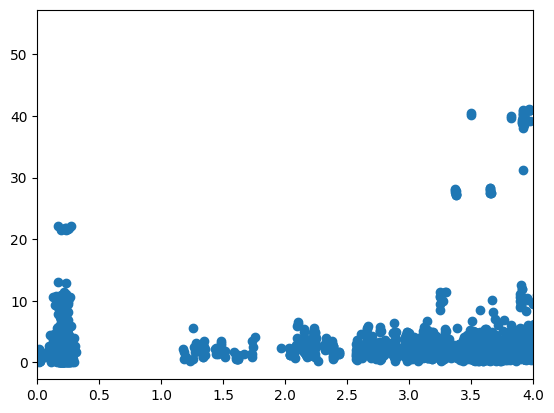

In [67]:
plt.scatter(X_, Y_)
plt.xlim((0,4))

(0.0, 400.0)

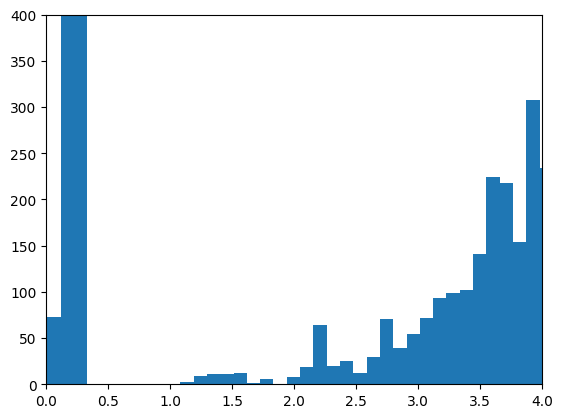

In [68]:
plt.hist(X_, bins=100)
plt.xlim((0, 4))
plt.ylim((0, 400))

In [69]:
filt = list(filter(lambda x: x < 0.5, X_))
len(filt)

1581

In [70]:
from collections import Counter

dupind = [(ind[i], X_[i], Y_[i]) for i in range(len(X_)) if (X_[i]<1.8) & (Y_[i]>5)] 
# print('\n'.join(map(str, dupind)))
indlist = [x[0][0] for x in dupind] + [x[0][1] for x in dupind]
print(badids := [item for item, count in Counter(indlist).items() if count > 2])
print(len(gvecs))
print(dupind)
gvecs.drop(index=gvecs.iloc[badids, :].index.to_list(), inplace=True)
gvecs.to_json(PurePath(datadir, outfile3))

[228, 266, 310, 337, 348, 368, 376, 398, 407, 431, 453, 470, 476, 499, 510, 517, 529, 575, 604, 616, 659, 682, 748, 751, 785, 883, 3, 14, 66, 85, 91, 196, 191, 142]
884
[((192, 3), 0.17070475, 9.981775487108914), ((199, 3), 0.23283613, 10.234688892627164), ((204, 3), 0.23429865, 9.847707190826387), ((228, 14), 0.1901705, 6.909141042942916), ((228, 66), 0.18771997, 6.413891824388121), ((228, 85), 0.24247622, 5.965634955113048), ((228, 91), 0.2540087, 5.694666113933014), ((228, 196), 0.19261713, 5.654302042789412), ((266, 137), 0.16396207, 22.08203087972786), ((266, 177), 0.22844844, 21.54471878545526), ((269, 3), 0.24833232, 10.062024645632741), ((302, 3), 0.23735602, 10.346070524708475), ((310, 228), 0.2285016, 6.018978364007811), ((317, 3), 0.122810476, 10.652874679848733), ((337, 14), 0.21659257, 10.913701775253665), ((337, 66), 0.20852129, 10.326828123285534), ((337, 85), 0.2311442, 9.898249637055619), ((337, 91), 0.24211322, 9.736461952187351), ((337, 191), 0.22046673, 6.2290766035

In [71]:
X_, Y_, ind = pair_mat(gvecs)
dupind = [(ind[i], X_[i], Y_[i]) for i in range(len(X_)) if (X_[i]<1.8) & (Y_[i]>5)] 
# print('\n'.join(map(str, dupind)))
indlist = [x[0][0] for x in dupind] + [x[0][1] for x in dupind]
print(badids := [item for item, count in Counter(indlist).items() if count > 2])
print(len(gvecs))
print(dupind)

[]
850
[((337, 69), 0.19187291, 6.203654711039562), ((509, 438), 0.20858566, 5.100939449214557), ((647, 369), 0.16039966, 5.530295886262131), ((674, 571), 0.20596515, 9.65914446017398), ((695, 392), 0.20025697, 5.98061823688211), ((695, 561), 0.19216432, 7.027795320917905), ((830, 64), 0.18453093, 5.045592507603139)]


In [72]:
for p, x, y in dupind:
    print(gvecs.iloc[p[0]]['pdbid'], gvecs.iloc[p[1]]['pdbid'], x, y)

7YCN 8HHZ 0.19187291 6.203654711039562
7JV6 7JV4 0.20858566 5.100939449214557
8ZBZ 8ZBY 0.16039966 5.530295886262131
7L5B 7L57 0.20596515 9.65914446017398
7PHG 7QTJ 0.20025697 5.98061823688211
7PHG 7QTI 0.19216432 7.027795320917905
8EL2 8ELJ 0.18453093 5.045592507603139


In [73]:
delpdbid = ['8HHZ', '7PHG', '7L57', '8ELJ', '7JV4' , '8ZBZ'] # Select by method (X-ray better) and resolution

In [74]:
for delind in delpdbid:
    print(gvecs[gvecs['pdbid'] == delind].index)
    # gvecs.drop(index=gvecs[gvecs['pdbid'] == delind].index, inplace=True) 


Index([82], dtype='int64')
Index([801], dtype='int64')
Index([656], dtype='int64')
Index([77], dtype='int64')
Index([504], dtype='int64')
Index([743], dtype='int64')


In [75]:
for delind in delpdbid:
    gvecs.drop(index=gvecs[gvecs['pdbid'] == delind].index, inplace=True) 

In [76]:
X_, Y_, ind = pair_mat(gvecs)
dupind = [(ind[i], X_[i], Y_[i]) for i in range(len(X_)) if (X_[i]<1.8) & (Y_[i]>5)] 
# print('\n'.join(map(str, dupind)))
indlist = [x[0][0] for x in dupind] + [x[0][1] for x in dupind]
print(badids := [item for item, count in Counter(indlist).items() if count > 2])
print(len(gvecs))
print(dupind)

[]
844
[]


In [77]:
# Drop duplicates
gvecs.drop_duplicates(
    subset=[
        'CDRH1', 'CDRH2', 'CDRH3', 
        'CDRL1', 'CDRL2', 'CDRL3',
    ], keep='last', inplace=True)
print(len(gvecs))

462


(0.0, 4.0)

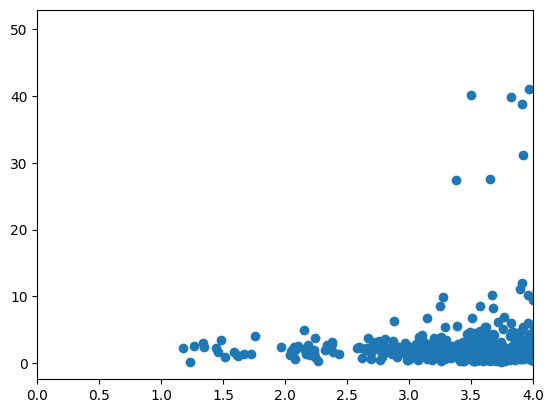

In [78]:
X_, Y_, ind = pair_mat(gvecs)
plt.scatter(X_, Y_)
plt.xlim((0,4))

(0.0, 50.0)

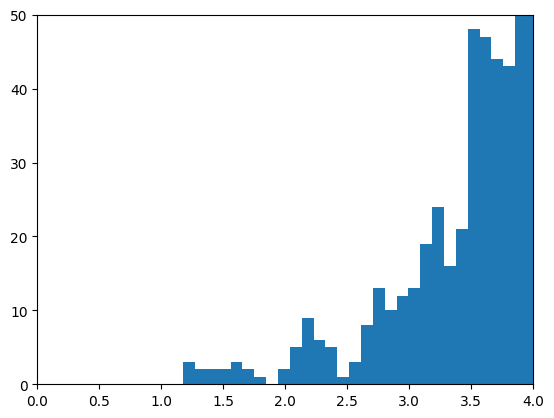

In [79]:
plt.hist(X_, bins=100)
plt.xlim((0, 4))
plt.ylim((0, 50))

In [80]:
len([x for x in X_ if x<3.5])

191

In [81]:
indlist = [(ind[i], x, Y_[i]) for i, x in enumerate(X_) if x < 1.8]
indlist

[((27, 4), 1.7587305, 4.097578172780224),
 ((92, 80), 1.1759461, 2.2080972273256987),
 ((161, 52), 1.4600028, 1.729796053355022),
 ((161, 80), 1.3357491, 2.948132305911392),
 ((161, 92), 1.4411681, 2.2682977802792044),
 ((212, 99), 1.6167454, 1.0011594229008876),
 ((248, 80), 1.6637499, 1.4352631208161233),
 ((248, 92), 1.587494, 1.690063694090132),
 ((248, 161), 1.4834151, 3.4293646072649553),
 ((309, 161), 1.608033, 1.2007051141004863),
 ((316, 99), 1.5117203, 0.8594322491496411),
 ((323, 27), 1.2640636, 2.527711135659647),
 ((342, 123), 1.7268654, 1.4343338190142811),
 ((408, 112), 1.3447063, 2.4843553727619554),
 ((447, 351), 1.2348756, 0.22732153636342783)]

In [82]:
indlist = [(ind[i], x, Y_[i]) for i, x in enumerate(X_) if 2.5 > x > 1.8]
indlist

[((80, 5), 2.2672446, 0.3121430074801502),
 ((80, 52), 1.9679048, 2.36888204689634),
 ((92, 5), 2.1696112, 2.0226928524200596),
 ((92, 52), 2.0440524, 1.823514048418212),
 ((161, 5), 2.3344867, 2.6468225970503156),
 ((248, 5), 2.2309873, 1.4762265362536435),
 ((248, 52), 2.0679653, 2.4166998389820704),
 ((309, 52), 2.164053, 1.4248970659564006),
 ((309, 80), 2.079434, 1.9196486001030857),
 ((309, 92), 2.1543107, 2.1784411176514347),
 ((309, 248), 2.1818478, 2.7157460779284897),
 ((314, 5), 2.0347636, 1.2879458831718207),
 ((314, 80), 2.2006423, 1.1917761399936315),
 ((314, 92), 2.2293863, 1.9932021171097285),
 ((314, 161), 2.3750916, 3.1773154368294634),
 ((314, 248), 2.183055, 1.5705178154402581),
 ((316, 212), 2.1916695, 1.6650223228154308),
 ((323, 4), 2.3807886, 1.6628931515942784),
 ((333, 314), 2.1876144, 1.6718755066765234),
 ((335, 106), 2.3745723, 2.885953963847302),
 ((366, 40), 2.0765903, 0.6493326684760687),
 ((387, 5), 2.3328438, 2.14738469222562),
 ((387, 52), 2.2369251, 

In [83]:
gvecs['Name'] = gvecs[['pdbid', 'H', 'L', 'R']].agg('_'.join, axis=1)


In [84]:
gvecs.drop(gvecs[gvecs.pdbid=='8EDF'].index, inplace=True)
gvecs.drop(gvecs[gvecs.pdbid=='8WFH'].index, inplace=True)
gvecs.drop(gvecs[gvecs.pdbid=='9JEB'].index, inplace=True)

In [85]:
gvecs.to_json(PurePath(datadir, outfile4))

In [86]:
# def procpdbchains(fname):
#     allnames = []
#     pdblist = []
#     allseq = set()
#     newdb = []

#     try:
#         gchids = {}
#         regchids = {}
#         if fname.endswith('.pdb'):
#             pdb_, pdbheader = pr.parsePDB(fname, header=True)
#             header = pdbheader['polymers']
#             title = pdbheader['title']
#         else:
#             pdb_, cifheader = pr.parseMMCIF(fname, header=True)
#             header = cifheader['polymers']
#             title = cifheader['title']
            
#         pdb = pdb_.select('protein')
#         pdbid = pdb.getTitle()    
#         excl = ('THE MOUSE ANTIBODY', 'MERS', 'TERMINAL DOMAIN', 'NUCLEOCAPSID', 'NTD', 'PEPTIDE', 'ACE2', \
#                'RABBIT', 'SARBECOVIRUS')
#         skip =False
#         for v in excl:
#             if v in title:
#                 skip = True
#                 break
#         else:
#             if 'NANOBOD' in title :
#                 skip = True
#             if 'ANTIBOD' in title or 'FAB' in title:
#                 skip = False
#         if skip:
#             return False, 'skip'
#         pdblist.append(fname)
#         chidsd = {
#         'RBD': [],
#         'L': [],
#         'H': [],
#         'SC': [],
#         'HorL': []
#         }
#         for p in header:
#             for k in chidsd.keys():
#                 if p.name in pnamesd[k]:
#                     chidsd[k].append(p.chid)
#                     gchids[p.chid] = k
#                     break

#         if (len(chidsd['RBD']) == 0) or \
#             (len(chidsd['H']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
#             (len(chidsd['L']) + len(chidsd['HorL']) + len(chidsd['SC']) == 0) or \
#             (len(chidsd['H']) + len(chidsd['L']) + len(chidsd['HorL']) + 2*len(chidsd['SC'])) < 2:
#             #        print( f'pdb {pdbid} does not contain RBD + H + L chains')
#             # print(chidsd)
#             return False, 'RBD + H-chain + L-chain check'
#         else:
#             allnames.extend(list(abname_fromheader(header, chidsd, title)))
#             #print(abname_fromheader(header, chidsd))

#         for c in chidsd['HorL'] + chidsd['SC'] + chidsd['H'] + chidsd['L']:
#             seq = next(pol.sequence for pol in header if pol.chid==c)
#             allseq.add(seq)
#             name = abname_frommolname(next(pol.name for pol in header if pol.chid==c))
#             if name == 'IGG' or name == 'IGK@':
#                 name = abname_frommolname(title)
#             newdb.append({'pdb': pdbid, 'seq': seq, 'chain': c, 'name': name})

#         return True, {'newdb': newdb, 'allseq': allseq, 'pdblist': pdblist} 
#     except KeyError:
#         return False, 'File KeyError'


In [87]:
# pr.confProDy(verbosity='critical')
# result = Parallel(n_jobs=24)(delayed(procpdbchains)(fname) for fname in tqdm(newfnames))
# print(len(result))

In [88]:
outfile4

'covidab_pdb_rbd_p4_1.json'

In [89]:
def strdiff(str1, str2):
    if len(str1) != len(str2):
        return 50
    else:
        res = 0
        for b, c in zip(str1, str2):
            if b!=c:
                res+=1
        return res
        
def cdrdiff(cdr1, cdr2):
    res = 0
    for s1, s2 in zip(cdr1, cdr2):
        res += strdiff(s1, s2)
    return res

In [90]:
def pairseq_mat(gvecs):
    Yv = np.vstack(gvecs['cont_rbd'].to_numpy())
    Xv = []
    for cdr in ('CDRH1', 'CDRH2', 'CDRH3', 'CDRL1', 'CDRL2', 'CDRL3'):
        Xv.append(gvecs[cdr].to_list())
    N = len(gvecs)
    vdistmat = np.zeros((N, N))
    X_, Y_ = [], []
    ind = []

    for i in range(N):
        a1 = Yv[i]
        x1 = [Xv[x][i] for x in range(6)]
        for j in range(i):
            a2 = Yv[j]
            x2 = [Xv[x][j] for x in range(6)]
            dg1 = np.linalg.norm(a2-a1)
            vdistmat[i, j] = dg1
            vdistmat[j, i] = dg1
            X_.append(cdrdiff(x1, x2))
            Y_.append(vdistmat[i, j])
            ind.append((i, j))

    return X_, Y_, ind

(0.0, 20.0)

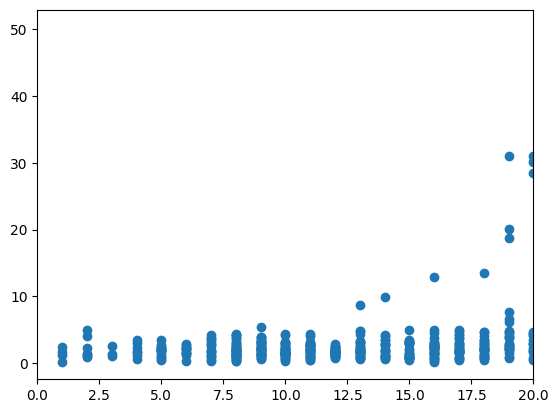

In [91]:
X_, Y_, ind =pairseq_mat(gvecs)
plt.scatter(X_, Y_)
plt.xlim((0, 20))

(0.0, 100.0)

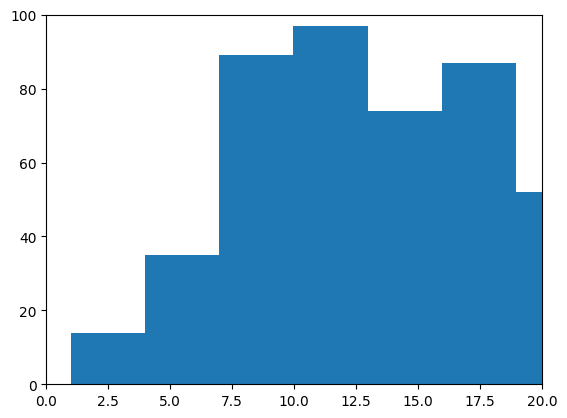

In [92]:
plt.hist(X_, bins=100)
plt.xlim((0, 20))
plt.ylim((0, 100))

In [93]:
count = Counter(X_)
print(sorted(count.items()))


[(1, 4), (2, 7), (3, 3), (4, 7), (5, 16), (6, 12), (7, 16), (8, 39), (9, 34), (10, 34), (11, 31), (12, 32), (13, 30), (14, 20), (15, 24), (16, 31), (17, 28), (18, 28), (19, 24), (20, 17), (21, 11), (22, 15), (23, 19), (24, 16), (25, 25), (26, 28), (27, 36), (28, 44), (29, 48), (30, 43), (31, 30), (32, 32), (33, 22), (34, 19), (35, 14), (36, 3), (37, 5), (38, 5), (39, 1), (40, 1), (41, 3), (43, 1), (51, 5), (52, 12), (53, 30), (54, 39), (55, 64), (56, 82), (57, 86), (58, 118), (59, 137), (60, 207), (61, 239), (62, 305), (63, 316), (64, 394), (65, 380), (66, 469), (67, 498), (68, 540), (69, 505), (70, 451), (71, 352), (72, 320), (73, 263), (74, 207), (75, 233), (76, 202), (77, 203), (78, 199), (79, 173), (80, 145), (81, 89), (82, 53), (83, 45), (84, 35), (85, 33), (86, 17), (87, 13), (88, 11), (89, 3), (90, 2), (91, 2), (92, 1), (100, 7), (101, 29), (102, 66), (103, 111), (104, 174), (105, 227), (106, 302), (107, 371), (108, 499), (109, 658), (110, 836), (111, 1083), (112, 1385), (113, 1

In [94]:
print([(x, y, ind[i]) for i, (x, y) in enumerate(zip(X_, Y_)) if (x <= 10) and (y>=5) ])

[(9, 5.42336568541167, (174, 160))]


In [95]:
print(gvecs.iloc[422], gvecs.iloc[396])

index                                                     926
H                                                           H
L                                                           L
R                                                           B
Wsum                                                       70
Wrh                                                        64
Wrl                                                         6
Whl                                                       175
CDRH3                                       ARDRVLYGRSFGWYFDV
CDRL3                                                QQYDNLPT
pdbid                                                    7UPY
Heavy       QVQLVQSGAEVKKPGASVKVSCKASGYTFTGTYIHWVRQAPGQGLE...
Light       DIQMTQSPSSLSASVGDRVTITCQASQDISDYLNWYQQQPGKAPKL...
CDRL1                                                  QDISDY
CDRL2                                                     DAS
CDRH1                                                GYTFTGTY
CDRH2   

In [96]:
print(gvecs.iloc[266], gvecs.iloc[92])

index                                                     679
H                                                           A
L                                                           B
R                                                           C
Wsum                                                       93
Wrh                                                        78
Wrl                                                        15
Whl                                                       159
CDRH3                                      AESPLGGGSGYSVSWFDP
CDRL3                                              QQYSNWPPWT
pdbid                                                    7DK0
Heavy       EVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...
Light       EIVMTQSPATLSVSPGERATLSCRASQSVSSNLAWYQQKPGQAPRL...
CDRL1                                                  QSVSSN
CDRL2                                                     GAS
CDRH1                                                GGTFSSYA
CDRH2   

In [97]:
print(gvecs.iloc[19], gvecs.iloc[115])

index                                                      59
H                                                           H
L                                                           L
R                                                           A
Wsum                                                       87
Wrh                                                        78
Wrl                                                         9
Whl                                                       151
CDRH3                                    ARELYYYDRSGYYVHDGFDI
CDRL3                                               QQYNTYPWT
pdbid                                                    8SIR
Heavy       QVQLQESGPGLVKPSETLSLTCTVSGGSVSSHNFHWSWIRQPPGKG...
Light       DIQMTQSPSTLSASVGDSVSITCRASQSISSWLAWYQQKPGTAPKL...
CDRL1                                                  QSISSW
CDRL2                                                     KAS
CDRH1                                              GGSVSSHNFH
CDRH2   

In [98]:
def seqH(seq, cdr1, cdr3):
    ind1 = seq.find(cdr1) - 23
    ind2 = seq.find(cdr3) + len(cdr3) + 7
    return seq[ind1:ind2+1]

def seqL(seq, cdr1, cdr3):
    ind1 = seq.find(cdr1) - 9
    ind2 = seq.find(cdr3) + len(cdr3) + 7
    return seq[ind1:ind2+1]
    
def seqdiff(df1, df2):
    seqH1 = seqH(df1.Heavy, df1.CDRH1, df1.CDRH3)
    seqH2 = seqH(df2.Heavy, df2.CDRH1, df2.CDRH3)
    seqL1 = seqL(df1.Light, df1.CDRL1, df1.CDRL3)
    seqL2 = seqL(df2.Light, df2.CDRL1, df2.CDRL3)
    return strdiff(seqH1, seqH2) + strdiff(seqL1, seqL2)

In [99]:
def allseq_mat(gvecs):
    Yv = np.vstack(gvecs['cont_rbd'].to_numpy())
    N = len(gvecs)
    vdistmat = np.zeros((N, N))
    X_, Y_ = [], []
    ind = []

    for i in range(N):
        a1 = Yv[i]
        df1 = gvecs.iloc[i]
        for j in range(i):
            a2 = Yv[j]
            df2 = gvecs.iloc[j]
            dg1 = np.linalg.norm(a2-a1)
            vdistmat[i, j] = dg1
            vdistmat[j, i] = dg1
            X_.append(seqdiff(df1, df2))
            Y_.append(vdistmat[i, j])
            ind.append((i, j))

    return X_, Y_, ind

In [100]:
X_, Y_, ind = allseq_mat(gvecs)


(0.0, 30.0)

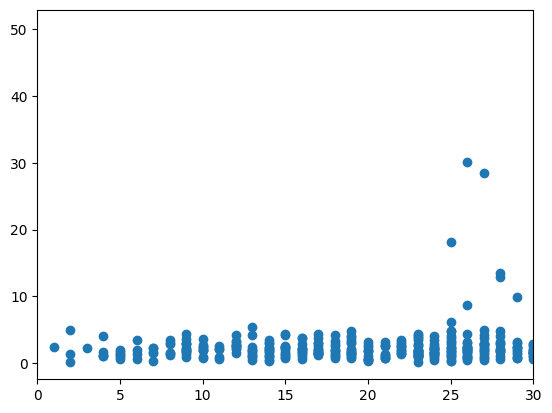

In [101]:
plt.scatter(X_, Y_)
plt.xlim((0, 30))

(array([1.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 5.0000e+00,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 4.0000e+00, 5.0000e+00,
        0.0000e+00, 6.0000e+00, 0.0000e+00, 1.3000e+01, 9.0000e+00,
        0.0000e+00, 5.0000e+00, 0.0000e+00, 1.0000e+01, 1.1000e+01,
        0.0000e+00, 1.4000e+01, 0.0000e+00, 1.2000e+01, 1.2000e+01,
        0.0000e+00, 1.5000e+01, 0.0000e+00, 1.1000e+01, 1.6000e+01,
        0.0000e+00, 1.2000e+01, 1.0000e+01, 0.0000e+00, 1.1000e+01,
        0.0000e+00, 2.5000e+01, 1.8000e+01, 0.0000e+00, 2.2000e+01,
        0.0000e+00, 2.2000e+01, 1.7000e+01, 0.0000e+00, 1.4000e+01,
        0.0000e+00, 1.2000e+01, 1.4000e+01, 0.0000e+00, 1.1000e+01,
        0.0000e+00, 1.4000e+01, 8.0000e+00, 0.0000e+00, 9.0000e+00,
        0.0000e+00, 1.3000e+01, 1.0000e+01, 0.0000e+00, 7.0000e+00,
        1.0000e+01, 0.0000e+00, 9.0000e+00, 0.0000e+00, 1.1000e+01,
        1.2000e+01, 0.0000e+00, 5.0000e+00, 0.0000e+00, 1.1000e+01,
        1.1000e+01, 0.0000e+00, 1.6000e+01, 0.00

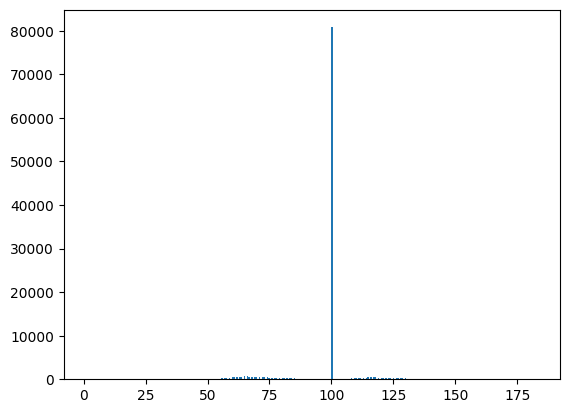

In [102]:
plt.hist(X_, bins=300)

In [103]:
print(sorted(Counter(X_).items()))

[(1, 1), (2, 3), (3, 1), (4, 5), (5, 6), (6, 4), (7, 5), (8, 6), (9, 13), (10, 9), (11, 5), (12, 10), (13, 11), (14, 14), (15, 12), (16, 12), (17, 15), (18, 11), (19, 16), (20, 12), (21, 10), (22, 11), (23, 25), (24, 18), (25, 22), (26, 22), (27, 17), (28, 14), (29, 12), (30, 14), (31, 11), (32, 14), (33, 8), (34, 9), (35, 13), (36, 10), (37, 7), (38, 10), (39, 9), (40, 11), (41, 12), (42, 5), (43, 11), (44, 11), (45, 16), (46, 16), (47, 14), (48, 7), (49, 13), (50, 12), (51, 52), (52, 83), (53, 110), (54, 168), (55, 177), (56, 197), (57, 285), (58, 319), (59, 321), (60, 411), (61, 441), (62, 549), (63, 515), (64, 584), (65, 654), (66, 647), (67, 625), (68, 599), (69, 615), (70, 563), (71, 552), (72, 486), (73, 409), (74, 431), (75, 404), (76, 363), (77, 371), (78, 305), (79, 322), (80, 256), (81, 282), (82, 281), (83, 212), (84, 183), (85, 193), (86, 146), (87, 142), (88, 140), (89, 116), (90, 103), (91, 74), (92, 92), (93, 94), (94, 90), (95, 127), (96, 149), (97, 157), (98, 129), (9

In [105]:
# Try to find Ab's name in pdb file
nonamedb = gvecs[gvecs.Name.str[:4] == gvecs.pdbid]

In [164]:
# Extract AB name from pdb header

def abname_frommolname(name1):
    name = name1.upper().replace('CHIAN', 'CHAIN').replace('ANITBODY', 'ANTIBODY').replace('LIGNT', 'LIGHT')

    word = re.split(r'[,\n? )(]+', name)
    if len(word) == 1:
        outname = name
    elif len(word) == 2 and word[0] in ('FAB', 'ANTIBODY', 'IG', 'IGL', 'SCFV'):
        outname = word[1]
    elif "PDI" in word:
        ind = word.index('PDI')
        if len(word)>ind+1:
            outname = word[ind] +'-' + word[ind+1]
        else:
            outname = 'PDI'
    elif "WCSL" in word:
        ind = word.index('WCSL')
        if len(word)>ind+1:
            outname = word[ind] +'-' + word[ind+1]
        else:
            outname = 'WCSL'
    elif len(word) == 2:
        outname = word[0]
    elif name.startswith('MONOCLONAL ANTIBODY'):
        outname = word[2]
    elif 'NEUTRALIZING ANTIBODY' in name:
        ind = word.index('NEUTRALIZING')
        if ind==0:
            outname = word[2]
        else:
            outname = word[ind-1]
    elif word[-2].startswith('ANTIBODY'):
        outname = word[-1]
    elif 'CHAIN H OF' in name:
        ind = word.index('CHAIN')
        if word[ind+3] in ('FAB', 'ANTIBODY'):
            if ind+4<len(word):
                outname = word[ind+4]
            else:
                outname = word[ind+3]
        else:
            outname = word[ind+3]
    elif 'CHAIN OF' in name:
        ind = word.index('CHAIN')
        if word[ind+2] in ('FAB', 'ANTIBODY'):
            if ind+3<len(word):
                outname = word[ind+3]
            else:
                outname = word[ind+2]
        elif word[ind+2] == 'HUMAN' and len(word)>ind+4:
            outname = word[ind+4]
        else:
            outname = word[ind+2]
    elif 'CHAINH OF' in name:
        ind = word.index('CHAINH')
        if word[ind+2] in ('FAB', 'ANTIBODY'):
            if ind+3<len(word):
                outname = word[ind+3]
            else:
                outname = word[ind+2]
        else:
            outname = word[ind+2]
    elif 'CHAIN FROM' in name:
        ind = word.index('CHAIN')
        if word[ind+2] in ('FAB', 'ANTIBODY'):
            if ind+3<len(word):
                outname = word[ind+3]
            else:
                outname = word[ind+2]
        else:
            outname = word[ind+2]
    elif (word[2] == 'CHAIN') and (word[0] == 'VARIABLE') and len(word)>3:
        outname = word[3]
    elif (word[2] == 'CHAIN') and (word[0] != 'THE') and (word[0] != 'VARIABLE'):
        outname = word[0]
    elif 'FAB OF ANTIBODY' in name:
        ind = word.index('FAB')
        outname = word[ind+3]
    elif 'FAB OF' in name:
        ind = word.index('FAB')
        outname = word[ind+2]
    elif word[1].startswith('ANTIBODY'):
        outname = word[0]
    elif 'FAB' in word[1:]:
        ind = word.index('FAB')
        if ind>=2 and word[1] in ('HEAVY', 'LIGHT'):
            outname = word[ind-2]
        elif ind==1 and 'ANTIBODY' == word[0] and len(word)>2:
            outname = word[2]
        else: 
            outname = word[ind-1]
    elif word[0] in ('FAB', 'ANTIBODY', 'FV', 'MAB', 'IGA') and ('CHAIN' in word[2:6] or 'SCFV' in word[2:6]):
        outname = word[1]
    elif word[1] in ('FAB', 'ANTIBODY', 'FV', 'IGG', 'IGA') and 'CHAIN' in word[3:6]:
        outname = word[0]
    elif word[1] in ('FAB', 'ANTIBODY', 'FV', 'FRAGMENT'):
        outname = word[0]
    elif word[-1] == 'CHAIN':
        outname = word[-3]
    else:
        outname = name
    
   
    if outname.startswith('RBD-'):
        outname = outname[4:]
    if outname == 'CLONE':
        ind = word.index('CLONE')
        outname = '-'.join(word[ind:ind+2])
    if outname.endswith('-FAB-HEAVY'):
        outname = outname[:-10]
    if outname.endswith('-HEAVY'):
        outname = outname[:-6]
    if outname.endswith(','):
        outname = outname[:-1]
    if outname.endswith('-VH') or outname.endswith('-VL'):
        outname = outname[:-3]
    if outname.endswith('-H') or outname.endswith('-L'):
        outname = outname[:-2]
    if outname.endswith('H') or outname.endswith('-L'):
        outname = outname[:-1]
    # Manual for 7WHZ
    if outname.startswith('C934_LIGHT'):
        outname = 'XMA01'
    elif outname.startswith('C4029_LIGHT'):
        outname = 'XMA04'
    elif outname.startswith('C1437_LIGHT'):
        outname = 'XMA09'
    elif outname.startswith('ENHANC'):
        outname = '8D2'
    return outname
    

In [170]:
s0 = set(['ANTIBODY', 'HEAVY', 'LIGHT', 'GAMMA1', 'FRAGMENT', 'IGG'])
for index, row in nonamedb.iterrows():
    fname = str(PurePath(datadir, 'pdb_raw', row['pdbid']+'.pdb'))
    if os.path.exists(fname := str(PurePath(datadir, 'pdb_raw', row['pdbid']+'.pdb'))):
        pdb_, pdbheader = pr.parsePDB(fname, header=True)
    else:
        fname = str(PurePath(datadir, 'pdb_raw', row['pdbid']+'.cif'))
        pdb_, pdbheader = pr.parseMMCIF(fname, header=True)
        
    header = pdbheader['polymers']
    title = pdbheader['title']
    chH = next(pol.name for pol in header if pol.chid==row['chids'][0])
    # chL = next(pol.name for pol in header if pol.chid==row['chids'][1])
    # print(chL)
    abname = abname_frommolname(chH)
    if len(abname)<20 and not abname in s0:
        gvecs.at[index, 'Name']= abname
        
    #print(row['pdbid'], row['chids'], abname, '\n', chH)
    # print(abname)


['002-02', '002-13', '002-S21B10', '002-S21F2', '034_32', '1-57', '10-28', '10-40', '10-5B', '10G4', '13G9', '14B1', '15033', '15033-7', '16L9', '17B10', '17T2', '1C3', '1D1', '1F', '1F11', '1G11', '1H2', '2-15', '2-36', '2-4', '2-43', '2-7', '20A7', '2130', '2196', '21B6', '2303', '25F9', '265', '282', '298', '2A10', '2B11', '2G1', '3500', '368-2', '3C11', '3D11', '3D2', '3E2', '3G10', '47D1', '47D11', '4G1-C2', '510A5', '52', '54042-4', '553-49', '5549-FAB', '55A8', '5817', '58G6', '5A6', '6-2C', '6I18', '6M6', '8-9D', '80', '812', '836', '87G7', '8G3', '8H12', '910-30', '9A8', 'A19-46.1', 'A19-61.1', 'A23-58.1', 'A34-2', 'A5-10', 'A8-1', 'AB-3467', 'AB08', 'AB1', 'AB159', 'AB188', 'AB23', 'AB246', 'AB326', 'AB354', 'AB4', 'AB445', 'AB496', 'AB5', 'AB709', 'AB712', 'AB765', 'AB803', 'AB816', 'AB847', 'ADG20', 'ADI-55688', 'ADI-62113', 'ANTIBODY', 'AZ090', 'B1-182.1', 'B38', 'BA.2-07', 'BA.2-10', 'BA.2-13', 'BA.2-23', 'BA.2-36', 'BA.4/5-1', 'BA.4/5-2', 'BA.4/5-35', 'BA.4/5-9', 'BA7054

In [171]:
gvecs.iloc[10]

index                                                      40
H                                                           C
L                                                           D
R                                                           Y
Wsum                                                       53
Wrh                                                        40
Wrl                                                        13
Whl                                                       174
CDRH3                                      VKDRHYDSAGYLVNGFHI
CDRL3                                               LQTYSYPVT
pdbid                                                    8BBN
Heavy       EVQLVESGGGLVQPGRSLRLSCVASGFTFEDYAMHWVRQVPGKGPE...
Light       DIQLTQSPSSLSASVRDRVTITCRASQSIDTYLNWYQQKPGKAPNL...
CDRL1                                                  QSIDTY
CDRL2                                                     AAS
CDRH1                                                GFTFEDYA
CDRH2   

In [ ]:
# # import os.path
# s0 = set(['CHAIN', 'FAB', 'OF',  'VARIABLE', '002-S21B10', 'ANTIBODY', 'DOMAIN', 'MONOCLONAL', 'NEUTRALIZING', 'IGG', '-', 'MUTANT', 'FV',\
#          'FROM', 'BISPECIFIC', 'FRAGMENT', 'THE', 'AN' ,'A', 'SCFV', 'CLONE', 'VERSION', 'REGION', 'CHAIN', 'HOMOLOGUE', \
#          'ANTIGEN-BINDING', 'SINGLE', 'HUMAN', 'FV-CLASP', 'BINDING', 'ANTIGEN', 'MAB', 'ARM', 'SARS-COV-2', '', 'HEAVY', 'LIGHT', \
#          'CHAINH', 'CHAINL', 'IMMUNOGLOBULIN', 'GAMMA1', 'RHD','GAMMA-1'])
# for index, row in nonamedb.iterrows():
#     fname = str(PurePath(datadir, 'pdb_raw', row['pdbid']+'.pdb'))
#     if os.path.exists(fname := str(PurePath(datadir, 'pdb_raw', row['pdbid']+'.pdb'))):
#         pdb_, pdbheader = pr.parsePDB(fname, header=True)
#     else:
#         fname = str(PurePath(datadir, 'pdb_raw', row['pdbid']+'.cif'))
#         pdb_, pdbheader = pr.parseMMCIF(fname, header=True)
        
#     header = pdbheader['polymers']
#     title = pdbheader['title']
#     chH = next(pol.name for pol in header if pol.chid==row['chids'][0])
#     chL = next(pol.name for pol in header if pol.chid==row['chids'][1])
#     # print(chL)
#     s1 = set(re.split(r'[,\n? )(]+', chH))
#     s2 = set(re.split(r'[,\n? )(]+', chL))
#     s3 = s1.intersection(s2)-s0
#     if len(s3)==1:
#         #print(s3)
#         pass
#     elif len(s3)==2 and 'PDI' in s3:
#         pass
#     elif len(s3)==2 and 'WCSL' in s3:
#         pass
#     else:
#         print(row['pdbid'], row['chids'], s3, s1-s0)

#     # print(fname, row['chids'])
#     #print(abname_frommolname(next(pol.name for pol in header if pol.chid==row['chids'][1])))